In [86]:
import pathlib

import pandas as pd
import polars as pl
from hydra import compose, initialize, utils
import seaborn as sns
from omegaconf import OmegaConf
from plotly import express as pex
from plotly import graph_objects as go
import plotly.io as pio
from flatten_dict import flatten

In [87]:
sns.set_style("dark")

In [88]:
pio.templates.default = "plotly_dark"

In [89]:
with initialize(config_path="configs", version_base="1.3"):
    config = compose("als_optim", return_hydra_config=True)

In [90]:
def collect_and_show_params(exp_dir: pathlib.Path):
    rows = []

    for file in exp_dir.rglob("cv_res.csv"):
        map_value = pl.scan_csv(file).filter(pl.col("name") == "MAP").collect().get_column("value").mean()
        params_path = file.parent / ".hydra" / "overrides.yaml"
        config = OmegaConf.load(params_path)
        config = flatten(OmegaConf.from_dotlist(OmegaConf.to_container(config)), reducer="dot")
        config["mean_MAP"] = map_value
        rows.append(config)
    
    als_hyperparams = pd.DataFrame.from_dict(rows)

    if not als_hyperparams.empty:
        return pex.parallel_coordinates(als_hyperparams, dimensions=als_hyperparams.columns, title="ALS hyperparams visualization")
    
    return go.Figure()

# ALS hyperparams

In [91]:
exp_dir = pathlib.Path(config.hydra.sweep.dir)

In [92]:
collect_and_show_params(exp_dir)

# LightFM

In [93]:
with initialize(config_path="configs", version_base="1.3"):
    config = compose("lightfm_optim", return_hydra_config=True)

In [94]:
collect_and_show_params(pathlib.Path(config.hydra.sweep.dir))

# Сравнение с другими алгоритмами

In [95]:
cross_base_dir = pathlib.Path("exp")

In [96]:
files = []

for dir in cross_base_dir.glob("cross_val_*"):
    files.extend(dir.rglob("cv_res.csv"))

In [97]:
dataframes = []

for file in files:
    dataframes.append(pl.read_csv(file))

files.clear()

In [98]:
cv_res = pl.concat(dataframes)
del dataframes

In [99]:
def show_data(metrics_data: pl.DataFrame, name: str):
    ax = sns.scatterplot(metrics_data.filter(pl.col("name").is_in([name])), x="fold", y="value", hue="model", style="name")
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.grid(True)
    return ax

<Axes: xlabel='fold', ylabel='value'>

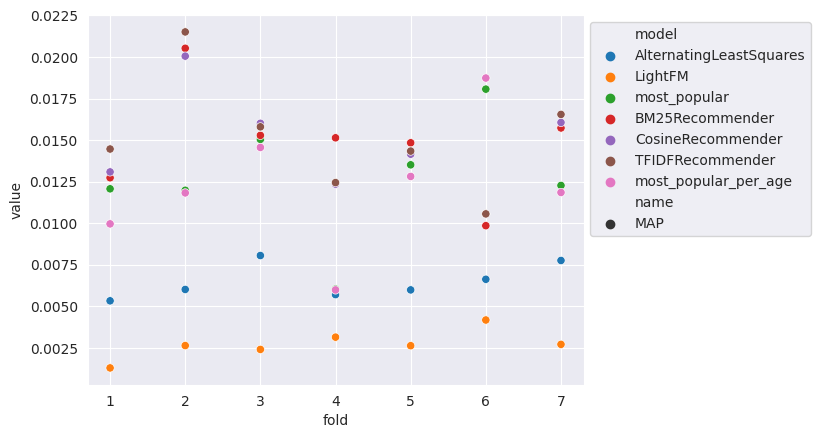

In [100]:
show_data(cv_res, "MAP")

<Axes: xlabel='fold', ylabel='value'>

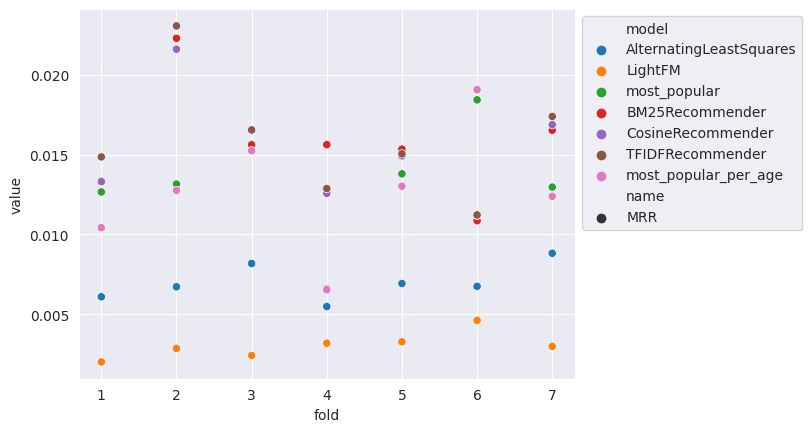

In [101]:
show_data(cv_res, "MRR")